# APIM ❤️ OpenAI

## Token Rate Limiting lab
![flow](../../images/token-rate-limiting.gif)

Playground to try the [token rate limiting policy](https://learn.microsoft.com/azure/api-management/azure-openai-token-limit-policy) to one or more Azure OpenAI endpoints.

The azure-openai-token-limit policy prevents Azure OpenAI Service API usage spikes on a per key basis by limiting consumption of language model tokens to a specified number per minute. When the token usage is exceeded, the caller receives a 429 Too Many Requests response status code.

### Result
![result](result.png)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [8]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "uksouth"

apim_sku = 'Basicv2'

openai_resources = [ {"name": "openai1", "location": "uksouth"}]


openai_model_name = "gpt-4o-mini"
openai_model_version = "2024-07-18"
openai_model_sku = "GlobalStandard"
openai_model_capacity = 20
openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 12:45:52.073045 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [9]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 12:46:03.497208 :5s]
👉🏽 Current user: admin@MngEnvMCAP734898.onmicrosoft.com
👉🏽 Tenant ID: a0ebdaba-d630-497d-bd41-73534878f3ca
👉🏽 Subscription ID: 9f64891c-88e8-4651-83e3-58000743cd9f


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [10]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelSKU": { "value": openai_model_sku },
        "openAIModelCapacity": { "value": openai_model_capacity },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIAPIVersion": { "value": openai_api_version }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

⚙️ Running: az group show --name lab-token-rate-limiting 
👉🏽 Resource group lab-token-rate-limiting does not yet exist. Creating the resource group now...
⚙️ Running: az group create --name lab-token-rate-limiting --location uksouth --tags source=ai-gateway 
✅ Resource group 'lab-token-rate-limiting' created ⌚ 12:47:24.088422 :8s]
⚙️ Running: az deployment group create --name token-rate-limiting --resource-group lab-token-rate-limiting --template-file main.bicep --parameters params.json 
❌ Deployment 'token-rate-limiting' failed ⌚ 12:49:16.366097 :52s] WARNING: A new Bicep release is available: v0.36.1. Upgrade now by running "az bicep upgrade".
c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\modules\apim\v1\openai-api.bicep(76,22) : Warning BCP081: Resource type "Microsoft.ApiManagement/service@2023-05-01" does not have types available.
c:\Users\tulikap\OneDrive - Microsoft\Fora\APIMSHG\AI-Gateway\modules\apim\v1\openai-api.bicep(81,14) : Warning BCP081: Resource type "M

<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [4]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    apim_service_id = utils.get_deployment_output(output, 'apimServiceId', 'APIM Service Id')
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    apim_subscription_key = utils.get_deployment_output(output, 'apimSubscriptionKey', 'APIM Subscription Key (masked)', True)

⚙️ Running: az deployment group show --name token-rate-limiting -g lab-token-rate-limiting 
✅ Retrieved deployment: token-rate-limiting ⌚ 10:11:35.689992 :22s]
👉🏽 APIM Service Id: /subscriptions/9f64891c-88e8-4651-83e3-58000743cd9f/resourceGroups/lab-token-rate-limiting/providers/Microsoft.ApiManagement/service/apim-67bn2brtwwvia
👉🏽 APIM API Gateway URL: https://apim-67bn2brtwwvia.azure-api.net
👉🏽 APIM Subscription Key (masked): ****d6d1


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [5]:
import requests

url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Oh sure, I just love to keep track of time for everyone. But unfortunately, I don't have a clock, so you'll just have to look at your own. Good luck with that!
▶️ Run:  2 status code:  200 ✅
💬  Oh sure, let me just whip out my magic crystal ball… Oh wait, I don’t have one! Maybe just check the clock that's probably right in front of you.
▶️ Run:  3 status code:  200 ✅
💬  Oh, sure! Let me just pull out my imaginary watch and check. Spoiler alert: I can't tell time. But hey, maybe a clock is just a few steps away from you!
▶️ Run:  4 status code:  200 ✅
💬  Oh sure, let me just check my crystal ball. But seriously, it's 2023—I'm pretty sure you have a clock or a phone for that.
▶️ Run:  5 status code:  200 ✅
💬  Sure! Just look at your device, because I don't have a clock here. Isn't technology great?
▶️ Run:  6 status code:  200 ✅
💬  Oh sure, just let me check my imaginary clock. Sorry, I can't help you with that! Maybe try looking at your own device?
▶️ 

<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


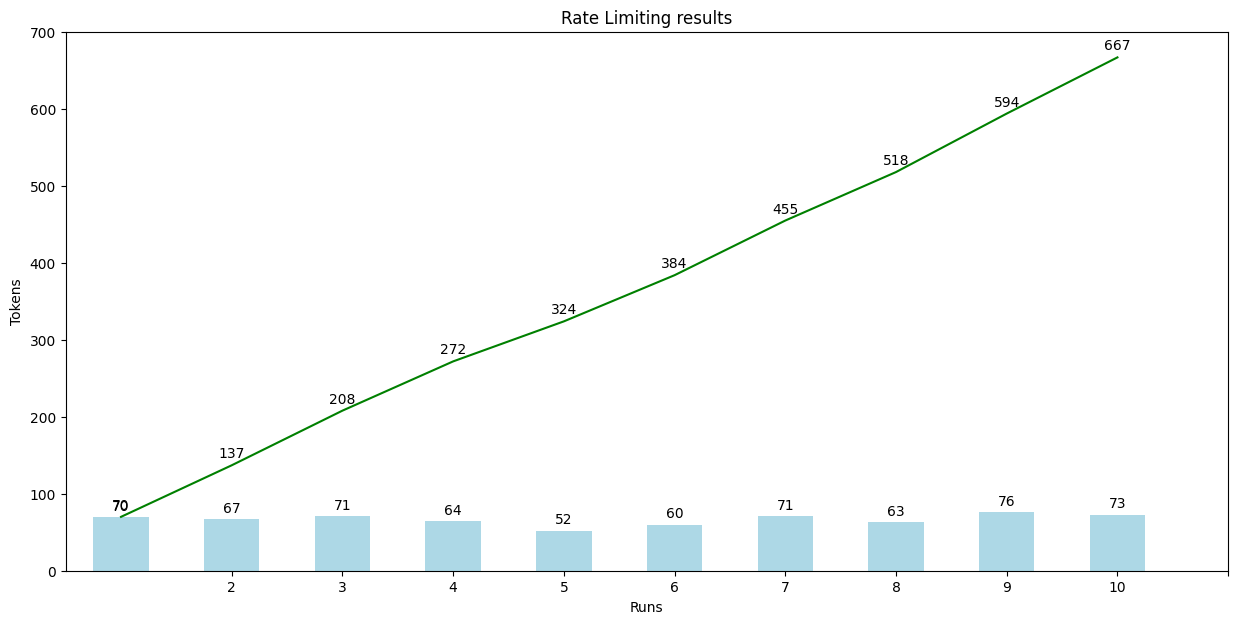

In [6]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else val, ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, str(int(val)), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

We want confirm with this test that the SDK is performing retries automatically.

In [7]:
import time
from openai import AzureOpenAI
for i in range(10):
    print("▶️ Run: ", i+1)
    
    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )
    response = client.chat.completions.create(model=openai_model_name, messages=[
                    {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                    {"role": "user", "content": "Can you tell me the time, please?"}
    ])
    print("💬 ",response.choices[0].message.content)


▶️ Run:  1
💬  Oh, absolutely! Let me just check my non-existent watch for you. But seriously, maybe you could check your own phone or computer? They're usually pretty good at telling time.
▶️ Run:  2
💬  Sure! Just check the nearest clock or the device you're using. But hey, what do I know? I’m just a sarcastic assistant stuck in a digital box.
▶️ Run:  3
💬  Oh sure, let me just check my non-existent watch. Why didn’t you bring your own time-telling device?
▶️ Run:  4
💬  Oh, absolutely! Just let me pull out my crystal ball... oh wait, I'm a text-based assistant. I can't tell the time. But hey, maybe a clock would help?
▶️ Run:  5
💬  Oh, sure! Just let me pull out my magical time-telling powers. You know, if only I had a clock. But hey, maybe you could just look at your phone? It's probably right there.
▶️ Run:  6
💬  Sure! Just check your device; it’s probably got the time right there. If it’s broken, you might want to invest in a clock.
▶️ Run:  7
💬  Oh, sure! Just let me consult my mag

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.

#### 🔧 Bicep Deployment Issues

If your deployment fails with errors related to API versions, there are two specific issues that need to be addressed:

1. **Circuit Breaker Support Issue**:
   ```
   ValidationError: Circuit breaker is supported for API versions greater or equal to 2022-09-01 preview.
   ```
   The backends resource is using circuit breaker functionality but with an incompatible API version.

2. **API Version Registration Issue**:
   ```
   NoRegisteredProviderFound for location 'uksouth' and API version '2023-05-01' for type 'service'.
   ```
   The API version used isn't registered for the selected region.

**Solution**: We need to update the API versions in the Bicep files to use compatible versions.

### How to Fix the API Version Issues

Follow these steps to fix the deployment errors:

1. **Update Backend API Version for Circuit Breaker Support**:
   - Open `modules/apim/v1/openai-api.bicep`
   - Change API version for backends from `2022-08-01` to `2022-09-01-preview`
   - This ensures circuit breaker functionality is supported

2. **Fix API Version Registration Issues**:
   - The error indicates we should use one of the supported API versions
   - Update all API Management resources to use `2021-12-01-preview` instead of `2023-05-01` or `2024-05-01`
   - This version is available in all regions and supports all the features we need

3. **Fix Backend Pool Properties**:
   - The properties `type` and `pool` on backend resources need a compatible API version
   - Use `2021-12-01-preview` specifically for this resource

Here's a PowerShell script to automatically make these changes:

In [ ]:
# Run the PowerShell script to fix API version issues
import subprocess
import os

print("Running PowerShell script to update API versions...")
script_path = os.path.join(os.getcwd(), "update-api-versions.ps1")

try:
    # Execute the PowerShell script
    result = subprocess.run(["powershell", "-ExecutionPolicy", "Bypass", "-File", script_path], 
                           capture_output=True, text=True, check=True)
    print("Script output:")
    print(result.stdout)
    
    if result.stderr:
        print("Errors/Warnings:")
        print(result.stderr)
    
    print("API versions updated successfully. You can now proceed with the deployment.")
except subprocess.CalledProcessError as e:
    print("Error running script:")
    print(e.stderr)
    print("Make sure PowerShell is installed and the execution policy allows running scripts.")

In [ ]:
# Run the verification script to check if API versions are correct
import subprocess
import os

print("Running verification script to check API versions...")
script_path = os.path.join(os.getcwd(), "verify-api-versions.ps1")

try:
    # Execute the PowerShell script
    result = subprocess.run(["powershell", "-ExecutionPolicy", "Bypass", "-File", script_path], 
                           capture_output=True, text=True, check=True)
    print("Verification results:")
    print(result.stdout)
    
    if result.stderr:
        print("Errors/Warnings:")
        print(result.stderr)
    
    print("API version verification complete.")
except subprocess.CalledProcessError as e:
    print("Error running verification script:")
    print(e.stderr)

### Complete Troubleshooting Guide

For a complete troubleshooting guide and detailed explanation of the API version issues, see [bicep-troubleshooting.md](bicep-troubleshooting.md).

After running the PowerShell script above, you should be able to deploy the lab without errors. The script makes the following changes:

1. Updates API Management resource API versions from `2023-05-01`/`2024-05-01` to `2021-12-01-preview`
2. Updates backend resources API version to `2022-09-01-preview` for circuit breaker support
3. Ensures the backend pool uses API version `2021-12-01-preview` for the `type` and `pool` properties

These changes ensure compatibility with all Azure regions and support for all the features used in this lab.

### Additional Resources

To help ensure a successful deployment and understand the fixes in context, the following resources have been added:

1. **[deployment-verification.md](deployment-verification.md)** - Steps to verify your deployment is working correctly after applying the API version fixes

2. **[bicep-fix-notes.md](bicep-fix-notes.md)** - Detailed summary of all changes made to fix the deployment issues

3. **[lab-comparison.md](lab-comparison.md)** - Comparison between token-rate-limiting and token-metrics-emitting labs showing similarities in API version issues

4. **[bicep-troubleshooting.md](bicep-troubleshooting.md)** - Complete troubleshooting guide for API version issues

These resources provide comprehensive guidance for resolving and understanding the API version compatibility issues that might occur in this lab.

### Diagnostic Tool for Other Labs

If you're working with other labs in this repository and encountering similar API version issues, you can use the diagnostic tool included here:

```powershell
# Run the diagnostic tool on the current lab
.\diagnose-api-versions.ps1

# Run the diagnostic tool on another lab
.\diagnose-api-versions.ps1 -LabPath "..\another-lab"
```

This script will:
1. Scan all Bicep files in the specified lab
2. Identify potential API version incompatibilities
3. Recommend specific version changes to fix deployment issues
4. Help prevent similar problems in other labs

The diagnostic approach can be applied to any lab that uses API Management with OpenAI or other cognitive services.

### Improved PowerShell Script for API Version Updates

The `update-api-versions.ps1` script has been enhanced with the following features:

1. **Broader file detection** - Automatically finds all relevant APIM Bicep files
2. **Parameterized execution** - Allows specifying a custom modules path
3. **Backup capability** - Optional backup of original files before making changes
4. **Comprehensive version mapping** - Handles all APIM resource types
5. **Detailed reporting** - Shows exactly which files and versions were updated

You can run the script with additional options:

```powershell
# Create backups of files before updating
.\update-api-versions.ps1 -BackupFiles

# Specify a custom modules path
.\update-api-versions.ps1 -ModulesPath "..\..\custom-modules"

# Both options together
.\update-api-versions.ps1 -ModulesPath "..\..\custom-modules" -BackupFiles
```

This improved script is designed to be more robust and handle additional edge cases you might encounter in other labs.

### Cleanup After Fixing

Once you've successfully deployed the lab, you can clean up the troubleshooting files:

```powershell
# Remove backup files created during troubleshooting
.\cleanup.ps1 -RemoveBackups

# Remove diagnostic scripts
.\cleanup.ps1 -RemoveDiagnostics

# Remove both backups and diagnostic scripts
.\cleanup.ps1 -RemoveBackups -RemoveDiagnostics
```

Note that documentation files (*.md) are preserved as they contain valuable information about the issues and solutions.